# Data Transformation and Visualization
Features
* Normalization: Normalize feature data to the range [0, 1].
* Smoothing: Apply a rolling window average to smooth data.
* Binning: Bin the data(x-axis) into specified numbers of bins with overlap support.
* Visualization: Visualize features vs pseudotime with optional transformations for the x-axis (binning) and y-axis (e.g., normalization).

## Usage:
### 1. Initialization
Create an instance of the Transform class by providing the path to the pseudotime CSV file and the directory containing the raw expression data.
```Python
transformer = Transform(
    pseudotime_csv_path="path_to_pseudotime.csv",
    raw_dir="path_to_raw_data"
)

```
### 2. Transformations
You can configure transformations for both the x-axis (e.g., binning) and the y-axis (e.g., normalization). The transformations are provided as dictionaries or lists:
1. x_transform: A dictionary to specify binning settings. For example:
    ```Python
    x_transform = {"method": "binning", "num_bins": 100, "overlap": 0.2}
    ```
2. y_transform: A list of functions to apply transformations to y-values (e.g., normalization). For example:
    ```Python
    y_transform = [transformer.normalize]
    ```
    Surported Transformation: [transformer.normalize, transformer.smooth]
3. Visualization
Call the visualize method to generate the plot. You need to provide a list of features (columns) to visualize over pseudotime.
    ```Python
    transformer.visualize(
        y_keys=["aSMA", "PanCK"],  # List of feature columns to visualize
        x_key="pseudotime",         # Column for x-axis (pseudotime)
        output_dir="output_directory",  # Directory to save the plot
        x_transform=x_transform,    # Transformation for the x-axis (optional)
        y_transform=y_transform,    # List of transformations for the y-axis (optional)
        show_plots=True             # Whether to display the plot (True or False)
    )
    ```


In [1]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from typing import Any, Dict, List, Optional, Callable
import matplotlib.pyplot as plt

##########################################
# Visualize feature trends vs pseudotime #
##########################################
class Transform:
    def __init__(self, pseudotime_csv_path: str, raw_dir: str):
        self.pseudotime_csv_path = pseudotime_csv_path
        self.raw_dir = raw_dir

    def normalize(self, data: pd.Series) -> pd.Series:
        """Normalize data to the range [0, 1]."""
        return (data - data.min()) / (data.max() - data.min())

    def smooth(self, data: pd.Series, window_size: int = 5) -> pd.Series:
        """Smooth data using a rolling window average."""
        return data.rolling(window=window_size, min_periods=1).mean()

    def binning(self, merged_df: pd.DataFrame, x_key: str, num_bins: int, overlap: float) -> pd.Series:
        """Bin the data for x_key into `num_bins` bins with `overlap`."""
        min_x, max_x = merged_df[x_key].min(), merged_df[x_key].max()
        bin_width = (max_x - min_x) / num_bins
        step_size = bin_width * (1 - overlap)
        bins = np.arange(min_x, max_x + step_size, step_size)
        return pd.cut(merged_df[x_key], bins=bins, labels=False, include_lowest=True)

    def visualize(
        self,
        y_keys: List[str],
        x_key: str = "pseudotime",
        output_dir: str = "./",
        x_transform: Optional[Dict[str, Any]] = None,
        y_transform: Optional[List[Callable]] = None,
        show_plots: bool = True,
    ):
        """
        Visualize features (e.g., biomarkers) vs pseudotime with x-axis binning and y-axis transformations.
        """
        # Load pseudotime CSV
        pseudotime_df = pd.read_csv(self.pseudotime_csv_path)
        pseudotime_df["region_id"] = pseudotime_df["region_id"].astype(str)
        pseudotime_df["cell_id"] = pseudotime_df["cell_id"].astype(str)

        # Initialize aggregated data
        aggregated_data = {x_key: []}
        for y_key in y_keys:
            aggregated_data[y_key] = []

        # Process each region in the pseudotime data
        for region_id in pseudotime_df["region_id"].unique():
            # Load the corresponding raw expression file
            expression_file_path = os.path.join(self.raw_dir, f"{region_id}.expression.csv")
            if not os.path.exists(expression_file_path):
                print(f"No matching data for region '{region_id}'. Skipping.")
                continue

            expression_df = pd.read_csv(expression_file_path)
            expression_df.rename(columns={"ACQUISITION_ID": "region_id", "CELL_ID": "cell_id"}, inplace=True)
            expression_df["region_id"] = expression_df["region_id"].astype(str)
            expression_df["cell_id"] = expression_df["cell_id"].astype(str)

            # Filter pseudotime data for the current region
            region_df = pseudotime_df[pseudotime_df["region_id"] == region_id]

            # Merge with pseudotime data
            merged_df = region_df.merge(expression_df, on=["region_id", "cell_id"], how="inner")

            # Apply x-axis binning by total number of bins
            if x_transform and x_transform.get("method") == "binning":
                num_bins = x_transform.get("num_bins", 100)
                overlap = x_transform.get("overlap", 0.2)
                merged_df["binned_" + x_key] = self.binning(merged_df, x_key, num_bins, overlap)
                binned_key = "binned_" + x_key
            else:
                binned_key = x_key

            # Apply y-axis transformations
            for y_key in y_keys:
                if y_key in merged_df.columns:
                    y_data = merged_df[y_key]
                    if y_transform:
                        for transform_func in y_transform:
                            y_data = transform_func(y_data)
                    merged_df[y_key] = y_data
                else:
                    print(f"Feature '{y_key}' not found in region '{region_id}'. Skipping.")

            # Aggregate data by bins
            if binned_key.startswith("binned_"):
                grouped = merged_df.groupby(binned_key).mean(numeric_only=True).reset_index()
            else:
                grouped = merged_df

            # Collect the aggregated results
            for y_key in y_keys:
                if y_key in grouped.columns:
                    aggregated_data[x_key].extend(grouped[binned_key] if binned_key.startswith("binned_") else grouped[x_key])
                    aggregated_data[y_key].extend(grouped[y_key])
                else:
                    aggregated_data[y_key].extend([np.nan] * len(grouped[x_key]))

        # Ensure all arrays in aggregated_data have the same length
        max_length = max(len(values) for values in aggregated_data.values())
        for key, values in aggregated_data.items():
            if len(values) < max_length:
                aggregated_data[key].extend([np.nan] * (max_length - len(values)))

        # Create a DataFrame
        aggregated_df = pd.DataFrame(aggregated_data)

        # Plot data
        plt.figure(figsize=(10, 6))
        for y_key in y_keys:
            if y_key in aggregated_df.columns:
                # Interpolate for smooth plotting
                x_values = aggregated_df[x_key]
                y_values = aggregated_df[y_key]

                # Drop NaN values for interpolation
                valid_indices = ~np.isnan(x_values) & ~np.isnan(y_values)
                x_values = x_values[valid_indices]
                y_values = y_values[valid_indices]

                # Use linear interpolation for smooth plotting
                interpolator = interp1d(x_values, y_values, kind="linear", fill_value="extrapolate")
                x_smooth = np.linspace(x_values.min(), x_values.max(), 500)  # Increase points for smooth curve
                y_smooth = interpolator(x_smooth)

                # Plot the trend
                plt.plot(
                    x_smooth,
                    y_smooth,
                    label=y_key,
                    alpha=0.8,
                    linestyle="-",
                )

        # Configure the plot
        plt.xlabel(x_key)
        plt.ylabel("Feature Value")
        plt.title("Feature Trends vs Pseudotime")
        plt.legend()
        plt.grid(True)

        # Save and/or display the plot
        output_path = os.path.join(output_dir, "features_vs_pseudotime_continuous.png")
        plt.savefig(output_path)
        if show_plots:
            plt.show()
        print(f"Plot saved to {output_path}")

/opt/anaconda3/envs/TIC/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/opt/anaconda3/envs/TIC/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


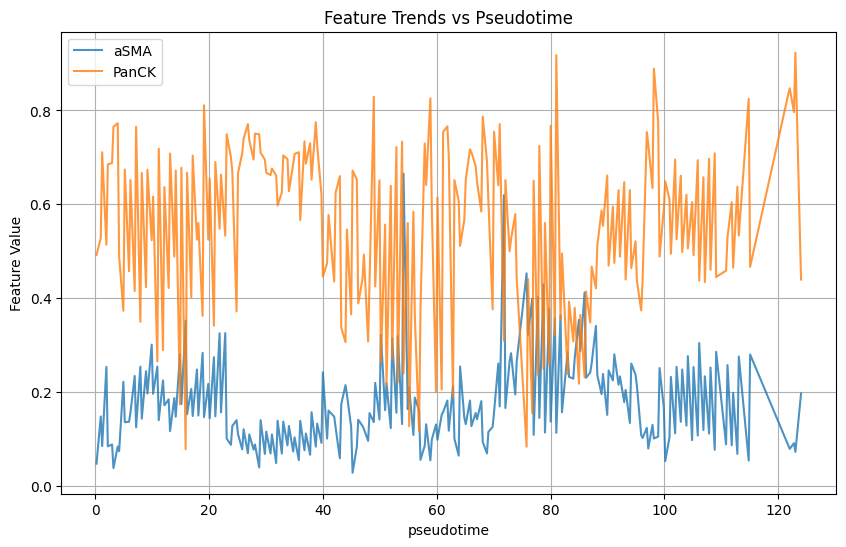

Plot saved to ../data/example/output/visualization/features_vs_pseudotime_continuous.png


In [40]:
transformer = Transform(
    pseudotime_csv_path="../data/example/output/embedding_analysis/composition_vectors/pseudotime/start_node_0/pseudotime.csv",
    raw_dir="../data/example/voronoi",
)

x_transform = {"method": "binning", "num_bins": 100, "overlap": 0.2}
y_transform = [transformer.normalize]

transformer.visualize(
    y_keys=["aSMA", "PanCK"],
    x_key="pseudotime",
    output_dir="../data/example/output/visualization",
    x_transform=x_transform,
    y_transform=y_transform
)




## Visualize Expression Data Across Cluster

/var/folders/sh/3c_fxl2x5pvd3tvv_5m23wtm0000gn/T/ipykernel_1316/2532342142.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_avg = merged_df.groupby('cluster')[biomarker].mean()
/var/folders/sh/3c_fxl2x5pvd3tvv_5m23wtm0000gn/T/ipykernel_1316/2532342142.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_avg = merged_df.groupby('cluster')[biomarker].mean()
/var/folders/sh/3c_fxl2x5pvd3tvv_5m23wtm0000gn/T/ipykernel_1316/2532342142.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current 

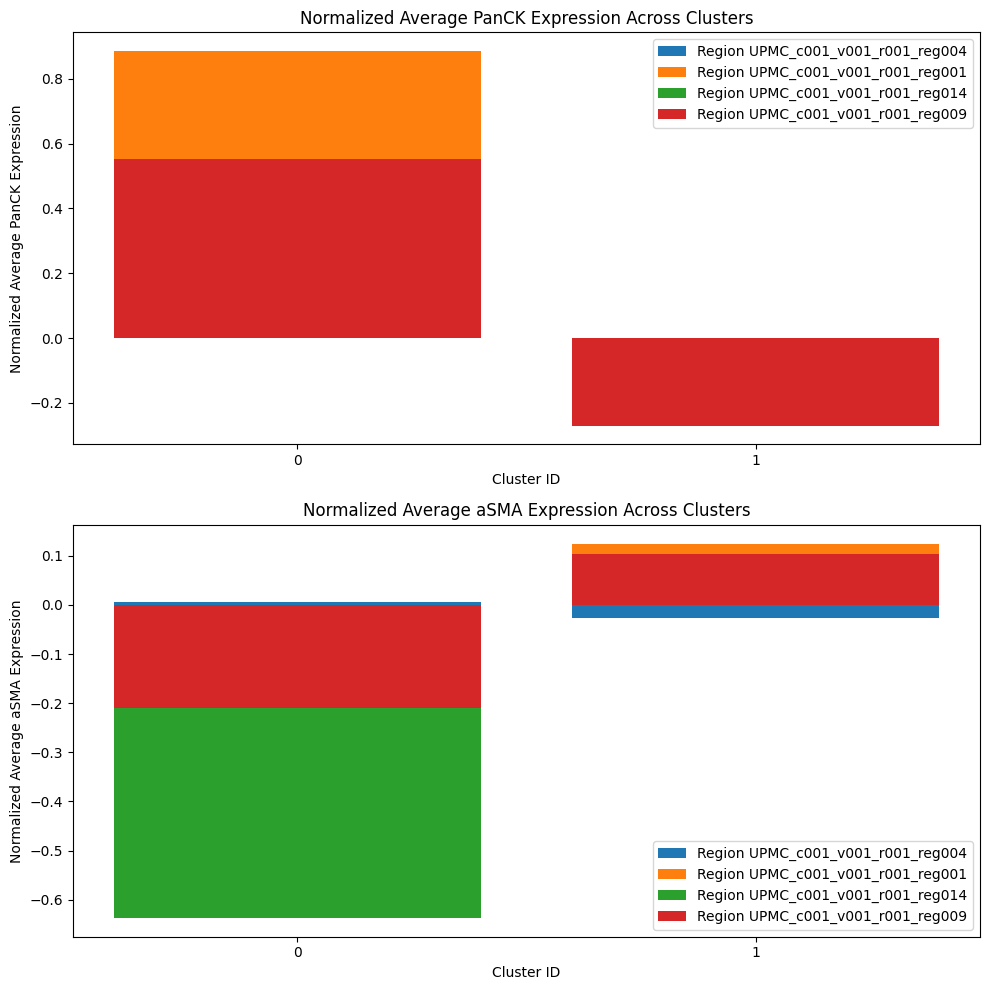

Plot saved to ../data/example/output/cluster_biomarker_avg_plot_normalized.png


In [66]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def load_expression_data(expression_dir):
    """
    Load expression data from the specified directory.
    """
    expression_data = {}
    
    # Loop through the files in the directory
    for file in os.listdir(expression_dir):
        if file.endswith(".expression.csv"):
            # Extract the full region_id from the file name (e.g., "UPMC_c001_v001_r001_reg001.expression.csv" -> "UPMC_c001_v001_r001_reg001")
            region_id = file.split('.')[0]
            file_path = os.path.join(expression_dir, file)
            expression_df = pd.read_csv(file_path)
            
            # Check if 'CELL_ID' exists in the data
            if 'CELL_ID' not in expression_df.columns:
                print(f"Warning: 'CELL_ID' not found in {file}")
                continue  # Skip this file if 'CELL_ID' is missing
            
            # Add the data to the dictionary
            expression_data[region_id] = expression_df
    
    return expression_data


def normalize_biomarker_data(expression_df, biomarker):
    """
    Normalize the biomarker data using StandardScaler.
    """
    scaler = StandardScaler()
    expression_df[biomarker] = scaler.fit_transform(expression_df[[biomarker]])
    return expression_df


def plot_cluster_biomarker_avg(cluster_csv_path, raw_dir, biomarker_keys, output_dir):
    """
    Plot the average biomarker expression for each cluster across different regions.
    """
    # 1. Load cluster data
    cluster_df = pd.read_csv(cluster_csv_path)
    cluster_df = cluster_df.rename(columns={'cell_id': 'CELL_ID'})
    
    # Ensure cluster column is categorical
    cluster_df['cluster'] = cluster_df['cluster'].astype('category')
    
    # Check if 'CELL_ID' exists in the cluster data
    if 'CELL_ID' not in cluster_df.columns or 'region_id' not in cluster_df.columns:
        print("Error: 'CELL_ID' or 'region_id' not found in the cluster data.")
        return
    
    # 2. Load biomarker expression data
    expression_data = load_expression_data(raw_dir)
    
    # 3. Initialize the plot
    fig, axes = plt.subplots(len(biomarker_keys), 1, figsize=(10, 5 * len(biomarker_keys)))
    
    if len(biomarker_keys) == 1:
        axes = [axes]  # Ensure axes is always a list
    
    # 4. Iterate through each biomarker key and plot the data
    for i, biomarker in enumerate(biomarker_keys):
        ax = axes[i]
        
        # Store the average biomarker expression for each cluster
        cluster_avg_biomarker = {}
        
        # 5. Process each region's data
        for region_id, expression_df in expression_data.items():
            # Check if the region has cluster data and expression data
            if region_id not in cluster_df['region_id'].values:
                print(f"Region {region_id} does not have cluster data. Skipping.")
                continue
            
            # Merge the cluster and expression data on the full region_id
            region_cluster_df = cluster_df[cluster_df['region_id'] == region_id]
            
            # Ensure 'CELL_ID' is in both DataFrames
            if 'CELL_ID' not in region_cluster_df.columns:
                print(f"Warning: 'CELL_ID' not found in cluster data for {region_id}. Skipping.")
                continue
            
            merged_df = pd.merge(region_cluster_df, expression_df, on='CELL_ID', how='left')
            
            # Normalize biomarker data
            merged_df = normalize_biomarker_data(merged_df, biomarker)
            
            # Calculate the average biomarker expression for each cluster
            cluster_avg = merged_df.groupby('cluster')[biomarker].mean()
            cluster_avg_biomarker[region_id] = cluster_avg
        
        # 6. Plot the results as a bar plot
        all_clusters = sorted(cluster_df['cluster'].unique())  # Get the sorted unique clusters
        
        # Prepare data for the bar plot: average expression per cluster
        for region_id, avg_biomarker in cluster_avg_biomarker.items():
            ax.bar(avg_biomarker.index.astype(str), avg_biomarker.values, label=f'Region {region_id}')
        
        # Set labels and title for each plot
        ax.set_xlabel("Cluster ID")
        ax.set_ylabel(f"Normalized Average {biomarker} Expression")
        ax.set_title(f"Normalized Average {biomarker} Expression Across Clusters")
        ax.legend()
    
    # 7. Save the plot to the output directory
    output_file = os.path.join(output_dir, "cluster_biomarker_avg_plot_normalized.png")
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()
    
    print(f"Plot saved to {output_file}")


# Example usage:
plot_cluster_biomarker_avg(
    cluster_csv_path="../data/example/output/embedding_analysis/composition_vectors/cluster_labels.csv",  # cluster data path
    raw_dir="../data/example/voronoi",  # biomarker expression data directory
    biomarker_keys=["PanCK", "aSMA"],  # Biomarker keys of interest
    output_dir="../data/example/output"  # Directory to save the plot
)
